In [1]:
import numpy as np
import qutip
from dimer import DimerParameters, get_c_ops, get_H_S, pstate_to_yz_bloch
import matplotlib.pyplot as plt
from pickle import load

In [2]:
lambdas = [[.5, .5], [.5, 1.5], [1.5, .5]]
ntraj_list= [10**4]
omega_S_list = [1]

T_list = [20]
# t_eval_list = [np.array([T]) for T in T_list]
t_eval_list = [np.linspace(T/2, T, 21) for T in T_list]

# solver = "trsolve"
solver = "mcsolve"
# solver = "gutzwiller"
if solver == "mcsolve":
    dt_list = [None]
elif solver == "trsolve" or solver == "gutzwiller":
    dt_list = [0.01]

no_click = False

psi0_list = [qutip.tensor(qutip.basis(2, 1), qutip.basis(2, 1))]

In [3]:
sim_list = [DimerParameters(omega_S_list[0],
                            lmbd_1,
                            lmbd_2,
                            get_H_S(omega_S_list[0]),
                            get_c_ops(lmbd_1, lmbd_2, omega_S_list[0]),
                            psi0_list[0],
                            t_eval_list[0],
                            ntraj_list[0],
                            solver,
                            dt_list[0],
                            no_click)
                for lmbd_1, lmbd_2 in lambdas]

In [4]:
data = []

for sim in sim_list:
    f = open(f"data/{str(sim)}.pkl", "rb")
    data.append(load(f))
    f.close()

In [5]:
def states_to_yz_bloch(states):
    r_l = np.empty(len(states))
    t_l = np.empty(len(states))
    r_r = np.empty(len(states))
    t_r = np.empty(len(states))
    for j, psi in enumerate(states):
        pstate_l = psi.ptrace(0)
        pstate_r = psi.ptrace(1)
        r_l[j], t_l[j] = pstate_to_yz_bloch(pstate_l)
        r_r[j], t_r[j] = pstate_to_yz_bloch(pstate_r)

    output = np.array([[r_l, t_l], [r_r, t_r]])

    return output

In [6]:
coords_full = []
for i, sim in enumerate(sim_list):
    # All saved states
    states_full = np.array(data[i][1].states, dtype=object).flatten()

    # Only final states
    # states_full = np.array(data[i][1].states, dtype=object)[:,-1].flatten()

    coords_full.append(states_to_yz_bloch(states_full))

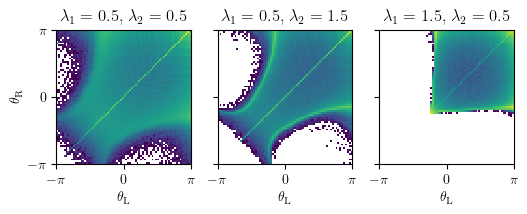

In [7]:
plt.style.use(["./config/stylelib/thesis.mplstyle", "./config/stylelib/manuscript_grid_1x3.mplstyle"])

bins = 72
binning_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
ticks = np.linspace(-np.pi, np.pi, 3)
tick_labels = [r"$-\pi$", r"$0$", r"$\pi$"]

fig, axs = plt.subplots(1, 3)
for i, sim in enumerate(sim_list):
    tl = coords_full[i][0][1]
    tr = coords_full[i][1][1]

    
    axs[i].hist2d(tl, tr,
                  density=True,
                  range=binning_range,
                  bins=bins,
                  norm="log")
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(tick_labels)
    axs[i].set_yticks(ticks)
    axs[i].set_yticklabels(tick_labels)
    axs[i].set_title(rf"$\lambda_1 = {sim.lmbd_1}$, $\lambda_2 = {sim.lmbd_2}$")
    axs[i].set(xlabel=r"$\theta_\mathrm{L}$", ylabel=r"$\theta_\mathrm{R}$")
    axs[i].set(aspect='equal')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig("plots/dimer-full-p-infty-mc.pdf")